Optimal Mean Reversion Trading: Mathematical Analysis And Practical Applications by Tim Siu-tang Leung, Xin Li

Video:  <a href = "https://youtu.be/vHzlZECzyPE">What is a pairs trade</A><br>
Video:  <a href="https://youtu.be/GdqVY1kZ4XI">Maximum Likelihood Estimation with Ornstein-Uhlenbeck (part 1)</A><br>
Video:  <a href="https://youtu.be/3906CWKhLqQ">Maximum Likelihood Estimation with Ornstein-Uhlenbeck (part 2)</A><br>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Ornstein-Uhlenbeck Process and Parameter Determination

$$ dX_t = \mu(\theta - X_t) dt + \sigma dW_t$$


When we wish to simulate this process, we use a differencing formula:
$$X_i - x_{i-1} = \mu(\theta - X_i) (t_i - t_{i-1}) + \sigma\sqrt{t_i - t_{i-1}}W_t$$

The optimal parameters can be calculated analytically.

First define

$$
X_x = \sum_{i=1}^N x_{i-1}
$$

$$
X_y = \sum_{i=1}^N x_i
$$

$$
X_{xx} = \sum_{i=1}^N (x_{i-1})^2
$$

$$
X_{xy} = \sum_{i=1}^N x_{i-1} x_i
$$

$$
X_{yy} = \sum_{i=1}^N (x_i)^2
$$

The optimal parameters are given by,


$$
\theta^* = \frac{X_y X_{xx} - X_x X_{xy}}
{N(X_{xx} - X_{xy}) - (X_x^2 - X_xX_y)}
$$

$$
\mu^* = -\frac{1}{\Delta t} \ln\left(
\frac{X_{xy} - \theta^*X_x - \theta^*X_y + N(\theta^*)^2}
{X_{xx} - 2\theta^*X_x + N(\theta^*)^2}\right)
$$


\begin{multline}
(\sigma^*)^2 = \frac{2\mu^*}{N(1-e^{-2\mu^*\Delta t})} (X_{yy} - 2e^{-\mu^*\Delta t} X_{xy} + e^{-2\mu^*\Delta t}X_{xx} \\
- 2\theta^* (1-e^{-\mu^*\Delta t})(X_y - e^{-\mu^*\Delta t})X_x + N(\theta^*)^2(1-e^{-\mu^*\Delta t})^2)
\end{multline}

In [35]:
def log_likelihood( parameters, S, dt ):
    theta = parameters[0]
    mu = parameters[1]
    sigma = parameters[2]
    
    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )
        
    N = S.size
    
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)
    
    prefactor = -1 / (2 * N * sigma0**2)
    sum_term = 0
    for i in range( 1, N ):
        x2 = S[i]
        x1 = S[i-1]
        
        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2
    
    f = (term1 + term2 + prefactor * sum_term)

    return f

def calculate_parameters(x, dt):
    
    N =x.size
    
    Xx  = np.sum(x[0:-1])
    Xy  = np.sum(x[1:])
    Xxx = np.sum(x[0:-1]**2)
    Xxy = np.sum(x[0:-1] * x[1:])
    Xyy = np.sum(x[1:]**2)

    theta0 = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) )

    mu0 = (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
        (Xxx - 2 * theta0 * Xx + N * theta0**2)
    mu0 = -1 / dt * np.log(mu0)

    prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
    term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2 * ( 1-np.exp(-mu0 * dt))**2

    sigma02 = prefactor * term
    sigma0 = np.sqrt(sigma02)
    
    return theta0, mu0, sigma0

##  Pairs Price

Our $X$ values will be the price of the pair over some range of time.

$$
X^{\alpha, \beta}_t = \alpha S_t^{(1)} - \beta S_t^{(2)}
$$

where $S_t^{(1)}$ and $S_t^{(2)}$ are the prices of stock one and two, respectively.  Likewise, $\alpha$ and $\beta$ are the numbers of shares of $S^{(1)}$ and $S^{(2)}$ owned.

For each potential pair, in other words for different values of $\alpha$ and $\beta$, we will use historical data to generate the OU parameters.

We will then sweep the values for $\alpha$ and $\beta$ (actually the ratio) and find the values that maximize the log likelihood.  We fix $\alpha$ and sweep $\beta$.

If we put $A$ dollars in $S^{(1)}$ we have
$$
\alpha = \frac{A}{S_0^{(1)}}.
$$

$$
\beta = \frac{B}{S_0^{(2)}}.
$$


##  Example

Our pairs will be GLD-GDX, and GLD-SLV.

Let's load in the GLD and GDX data.

Data fro Aug 2011 to May 2012

$N = 200$, and $\Delta t = 1 / 252$.


In [36]:
GDX = pd.read_csv('GDX_historical.csv')
GLD = pd.read_csv('GLD_historical.csv')

gld = GLD['Adj Close'].to_numpy()
gdx = GDX['Close'].to_numpy()

gld = gld[3:203]
gdx = gdx[3:203]

N = gld.size
dt = 1/252
print(N)

200


In [37]:
B_over_A = np.linspace(0.001, 1, 1000)
likelihood_gld_gdx = []

for value in B_over_A:
    alpha = 1 / gld[0]
    
    beta = value / gdx[0]
    
    X = alpha * gld - beta * gdx
    
    parameters = calculate_parameters(X, dt)
    likelihood_gld_gdx.append(log_likelihood(parameters, X, dt))

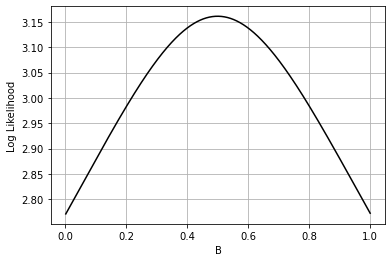

In [38]:
B = B_over_A
plt.plot(B, likelihood_gld_gdx, 'k')
plt.xlabel('B')
plt.ylabel('Log Likelihood')
plt.grid()

In [39]:
V = np.amax(likelihood_gld_gdx)
ind = np.where(likelihood_gld_gdx == V)
ind = ind[0]
print( B[ind] )

[0.499]
